In [1]:
import numpy as np # For arithmetics and arrays
import math # For inbuilt math functions
import pandas as pd # For handling data frames
import collections # used for dictionaries and counters
from itertools import permutations # used to find permutations

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function to easily split data into training and testing samples
from sklearn.decomposition import PCA # Principal component analysis used to reduce the number of features in a model
from sklearn.preprocessing import StandardScaler # used to scale data to be used in the model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

import pickle # To save the trained model and then read it

import seaborn as sns # Create plots
sns.set(style="ticks")
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('D:\My folder\dataset\Langdata.csv') # Read raw data
df = df.dropna() # remove null values for the "text" column
df.describe()
#df['text'] = df['text'].astype(str) # Convert the column "text" from object to a string in order to operate on it
#df['language'] = df['language'].astype(str)

,text,language
count,2761,2761
unique,2752,3
top,Take potluck,English
freq,2,2055


In [7]:
df['text'] = df['text'].astype(str) # Convert the column "text" from object to a string in order to operate on it

In [11]:
df['language'] = df['language'].astype(str)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 2838
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2761 non-null   object
 1   language  2761 non-null   object
dtypes: object(2)
memory usage: 64.7+ KB


In [13]:
# Define a list of commonly found punctuations
punc = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
vowels=['a','e','i','o','u']
# Define a list of double consecutive vowels which are typically found in Dutch and Afrikaans languages
same_consecutive_vowels = ['aa','ee', 'ii', 'oo', 'uu'] 
consecutive_vowels = [''.join(p) for p in permutations(vowels,2)]
dutch_combos = ['ij']

In [14]:
# Create a pre-defined set of features based on the "text" column in order to allow us to characterize the string
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
df['character_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['character_count'] + 1)
df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc]))
df['v_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'v']))
df['w_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'w']))
df['ij_char_count'] = df['text'].apply(lambda x : sum([any(d_c in a for d_c in dutch_combos) for a in x.split()]))
df['num_double_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in same_consecutive_vowels) for a in x.split()]))
df['num_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in consecutive_vowels) for a in x.split()]))
df['num_vowels'] = df['text'].apply(lambda x : sum([any(v in a for v in vowels) for a in x.split()]))
df['vowel_density'] = df['num_vowels']/df['word_count']
df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['character_count']),axis=1)
df['num_exclamation_marks'] =df['text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))
df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in punc))
df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))
df['num_repeated_words'] = df['text'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))
df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
df['encode_ascii'] = np.nan

In [15]:
df

,text,language,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,ij_char_count,num_double_consec_vowels,...,vowel_density,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words,num_repeated_words,words_vs_unique,encode_ascii
0,Ship shape and Bristol fashion,English,5,26,0.185185,0,0,0,0,0,...,1.000000,2,0.076923,0,0,0,5,0,1.000000,NaN
1,Know the ropes,English,3,12,0.230769,0,0,1,0,0,...,1.000000,1,0.083333,0,0,0,3,0,1.000000,NaN
2,Graveyard shift,English,2,14,0.133333,0,1,0,0,0,...,1.000000,1,0.071429,0,0,0,2,0,1.000000,NaN
3,Milk of human kindness,English,4,19,0.200000,0,0,0,0,0,...,1.000000,1,0.052632,0,0,0,4,0,1.000000,NaN
4,Touch with a barge-pole - Wouldn't,English,6,29,0.200000,3,0,2,0,0,...,0.833333,2,0.068966,0,0,3,6,0,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,Daar’s ‘n geurtjie aan.,Afrikaans,4,20,0.190476,1,0,0,0,2,...,0.750000,1,0.050000,0,0,1,4,0,1.000000,NaN
2835,Men's evil manners live in brass; their virtue...,English,12,54,0.218182,2,3,3,0,0,...,1.000000,1,0.018519,0,0,2,11,1,0.916667,NaN
2836,Go-faster,English,1,9,0.100000,1,0,0,0,0,...,1.000000,1,0.111111,0,0,1,1,0,1.000000,NaN
2837,Red tape,English,2,7,0.250000,0,0,0,0,0,...,1.000000,1,0.142857,0,0,0,2,0,1.000000,NaN


In [16]:
for i in range(len(df)):
    try:
        df['text'].iloc[i].encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        df['encode_ascii'].iloc[i] = 0
    else:
        df['encode_ascii'].iloc[i] = 1

C:\Users\43667\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
df.groupby('language').mean().T

language,Afrikaans,English,Nederlands
word_count,10.503912,4.072506,5.746269
character_count,43.541471,16.841849,26.074627
word_density,0.234060,0.226490,0.209378
punc_count,1.507042,0.317275,1.223881
v_char_count,0.652582,0.126521,0.358209
w_char_count,0.904538,0.291971,0.522388
ij_char_count,0.000000,0.000000,0.268657
num_double_consec_vowels,1.696401,0.178589,1.014925
num_consec_vowels,2.773083,0.536253,1.134328
num_vowels,9.114241,3.742579,5.671642


In [18]:
df.corr(method ='pearson')

,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,ij_char_count,num_double_consec_vowels,num_consec_vowels,num_vowels,vowel_density,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words,num_repeated_words,words_vs_unique,encode_ascii
word_count,1.000000,0.963818,0.284142,0.656144,0.499937,0.576566,0.002617,0.714460,0.769932,0.985911,-0.158172,0.408048,-0.449626,0.161356,0.054530,0.656144,0.985286,0.785662,-0.609634,-0.500432
character_count,0.963818,1.000000,0.066516,0.685772,0.535066,0.579176,0.012066,0.737948,0.801404,0.960918,-0.089117,0.409393,-0.486624,0.174488,0.065903,0.685772,0.950250,0.751124,-0.570829,-0.506098
word_density,0.284142,0.066516,1.000000,0.001107,0.002239,0.061311,-0.032624,0.050620,0.042554,0.249241,-0.356830,0.081018,0.062398,-0.011030,0.001162,0.001107,0.306803,0.143736,-0.178659,-0.077037
punc_count,0.656144,0.685772,0.001107,1.000000,0.370564,0.374964,0.042030,0.548477,0.563451,0.621920,-0.228459,0.385474,-0.287332,0.205043,0.119390,1.000000,0.652952,0.487491,-0.379424,-0.392489
v_char_count,0.499937,0.535066,0.002239,0.370564,1.000000,0.233034,0.022992,0.389565,0.424615,0.499093,-0.038331,0.250590,-0.249199,0.095870,0.025231,0.370564,0.502898,0.367544,-0.287014,-0.337758
w_char_count,0.576566,0.579176,0.061311,0.374964,0.233034,1.000000,0.005225,0.468219,0.413632,0.580779,-0.002004,0.204286,-0.280512,0.111205,0.101982,0.374964,0.562223,0.464511,-0.353433,-0.298730
ij_char_count,0.002617,0.012066,-0.032624,0.042030,0.022992,0.005225,1.000000,0.000365,-0.010899,0.012548,0.047971,-0.021422,-0.048555,-0.007353,-0.007675,0.042030,0.007278,-0.016064,0.017089,0.023861
num_double_consec_vowels,0.714460,0.737948,0.050620,0.548477,0.389565,0.468219,0.000365,1.000000,0.588212,0.707235,-0.079424,0.245026,-0.352140,0.174573,0.040402,0.548477,0.705972,0.563045,-0.412084,-0.471362
num_consec_vowels,0.769932,0.801404,0.042554,0.563451,0.424615,0.413632,-0.010899,0.588212,1.000000,0.776344,-0.044574,0.286679,-0.401469,0.121268,0.033055,0.563451,0.759246,0.604320,-0.452598,-0.436547
num_vowels,0.985911,0.960918,0.249241,0.621920,0.499093,0.580779,0.012548,0.707235,0.776344,1.000000,-0.022570,0.357889,-0.480243,0.158128,0.057858,0.621920,0.968959,0.782950,-0.614507,-0.450493


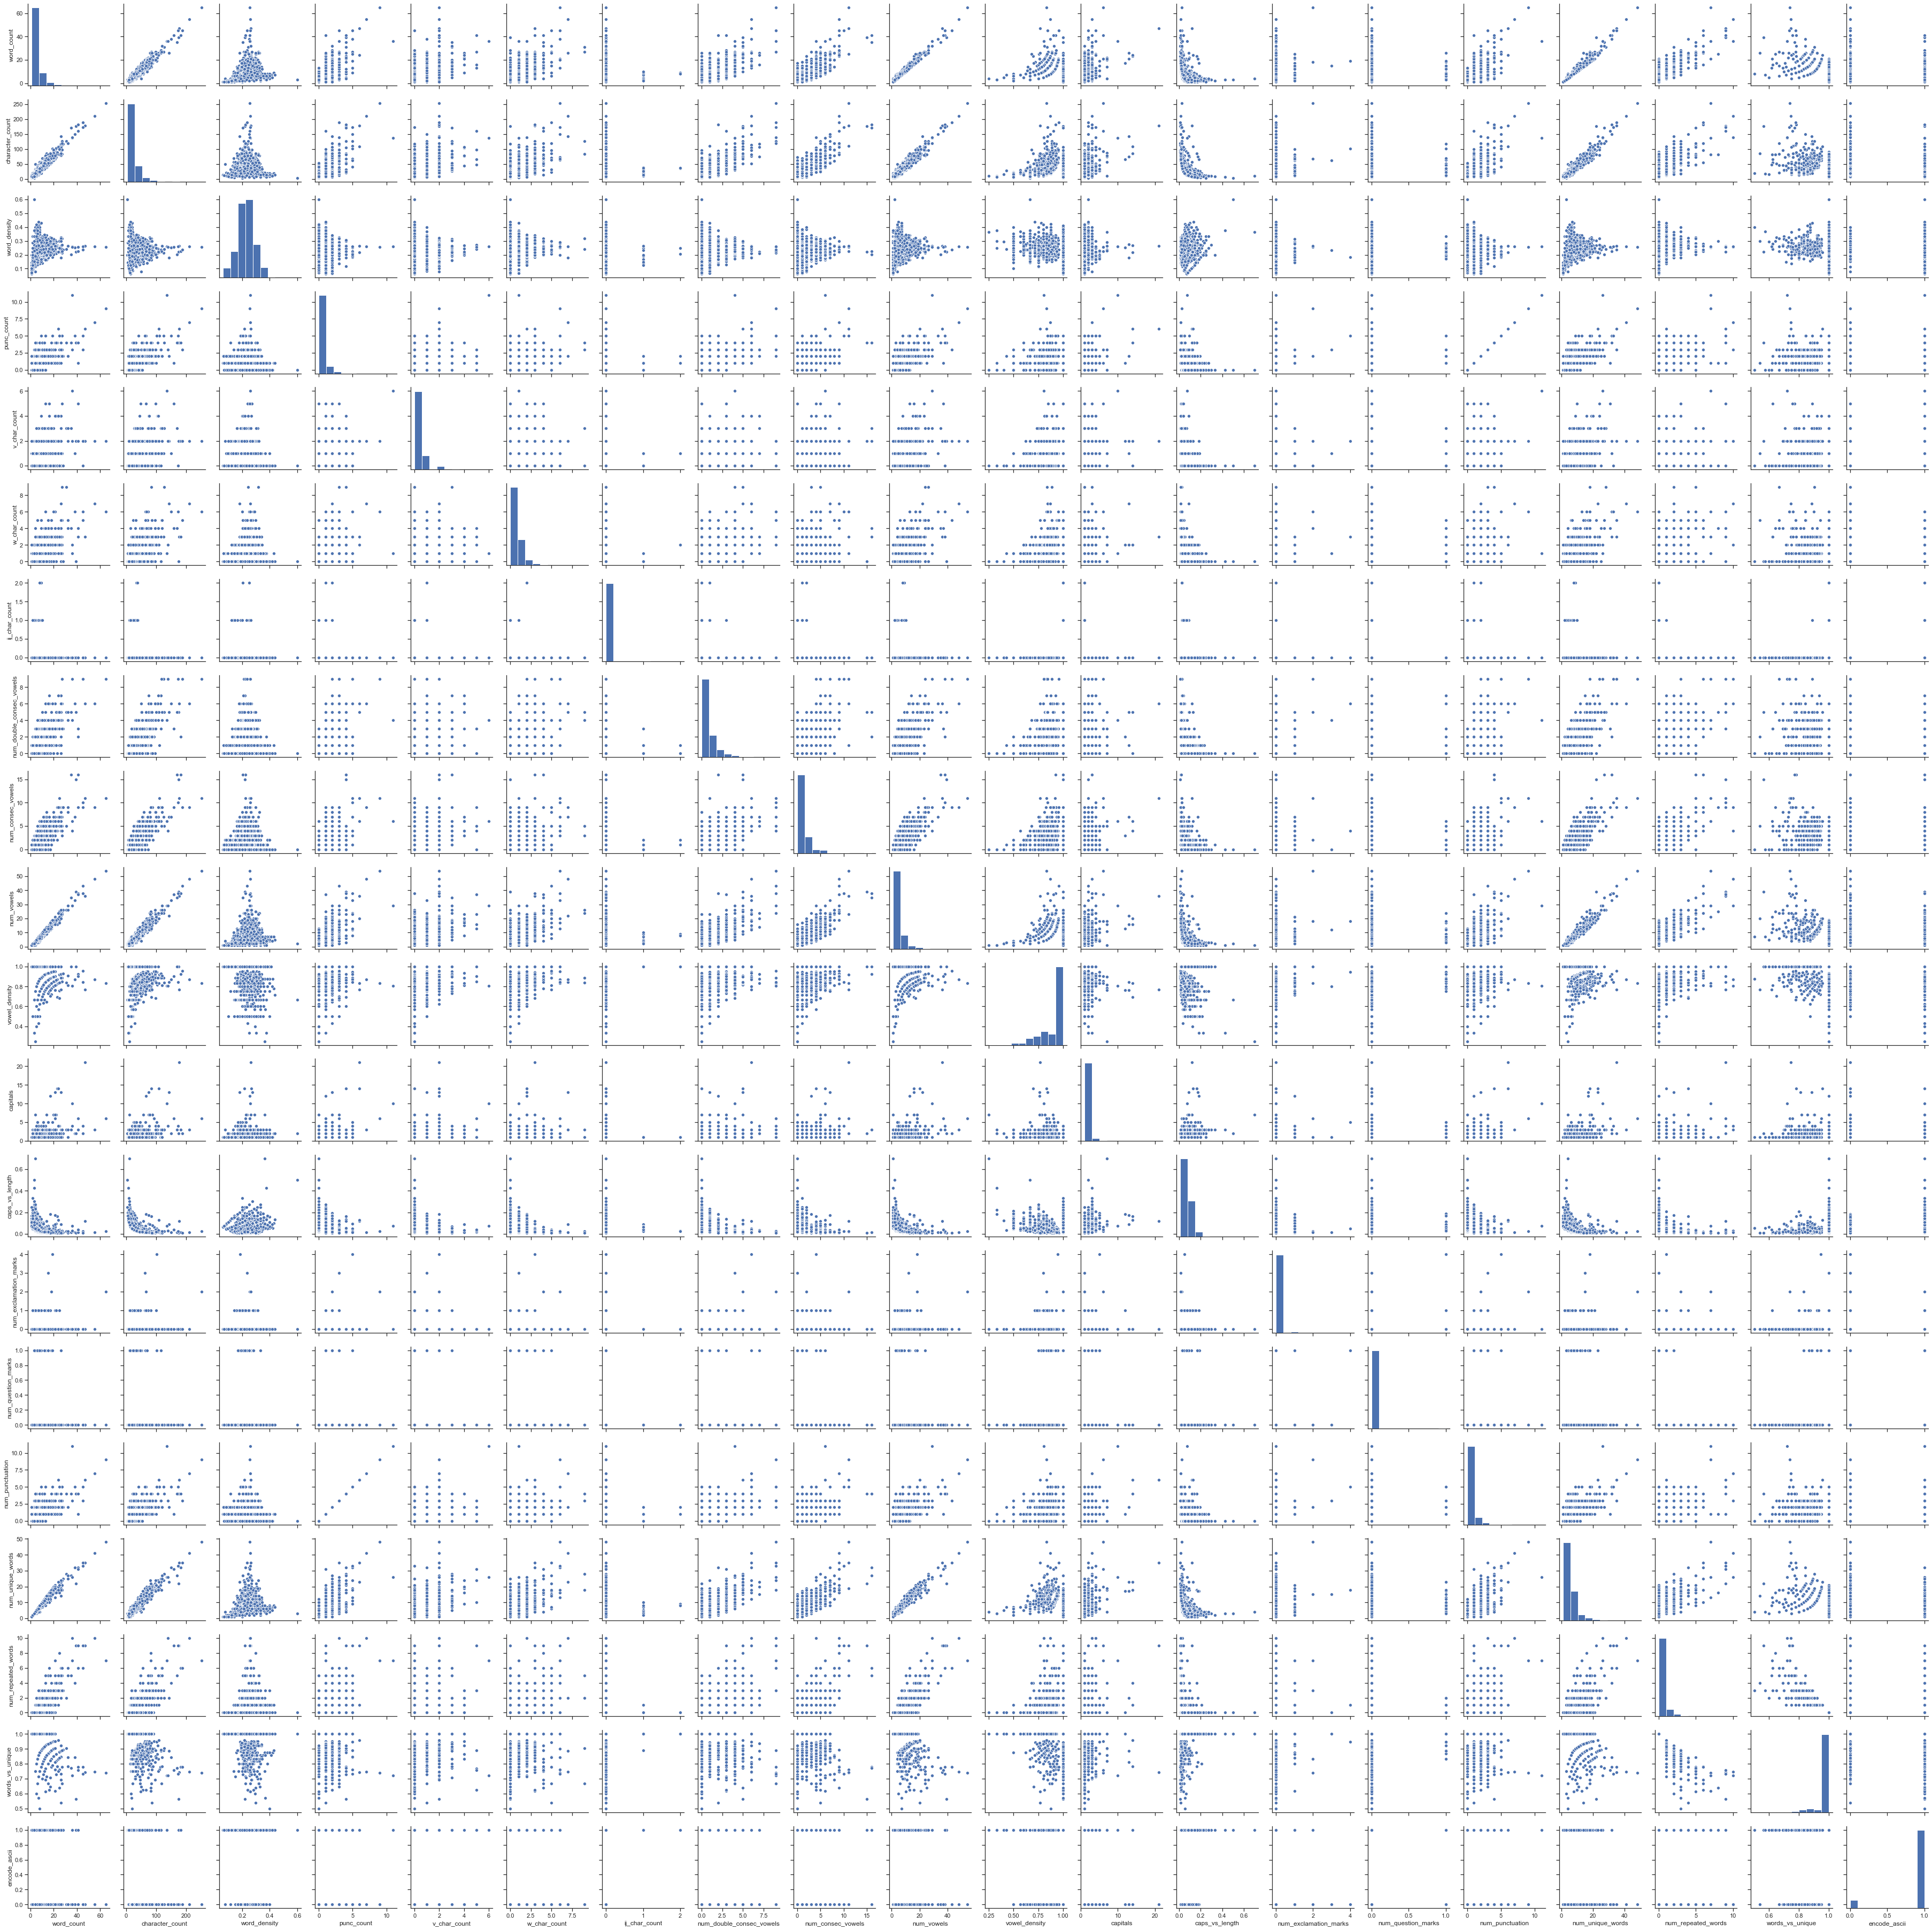

In [19]:
sns.pairplot(df)

In [20]:
#split dataset into features and target variable
feature_cols = list(df.columns)[2:]
X = df[feature_cols] # Features
y = df[['language']] # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% train and 20% test

In [22]:
# Standardize the data
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Transform both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Make an instance of the model to retain 95% of the variance within the old features.
pca = PCA(.95)
pca.fit(X_train)

print('Number of Principal Components = '+str(pca.n_components_))
# Number of Principal Components = 13

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Number of Principal Components = 13


In [24]:
pca

PCA(n_components=0.95)

In [25]:
dt_clf = DecisionTreeClassifier() # Create Decision Tree classifer object
dt_clf = dt_clf.fit(X_train,y_train) # Fit/Train Decision Tree Classifer on training set

In [26]:
dt_clf

DecisionTreeClassifier()

In [29]:
#Save model to file in the current working directory so that it can be imported and used.
# I use the pickle library to save the parameters of the trained model
pkl_file = "decision_tree_model.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(dt_clf, file)

# Load previously trained model from pickle file
with open(pkl_file, 'rb') as file:
    dt_clf = pickle.load(file)

dt_clf # parameters of the Decision Tree model are shown below and can be further optimized to improve model performance

y_pred = dt_clf.predict(X_test) #Predict the response for test dataset

In [30]:
accuracy_score_dt = accuracy_score(y_test, y_pred)

In [31]:
accuracy_score_dt

0.8752260397830018

C:\Users\43667\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['English', 'Afrikaans', 'Nederlands'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0.5, 1.0, 'Decision Tree Model Accuracy Score = 87.52%')

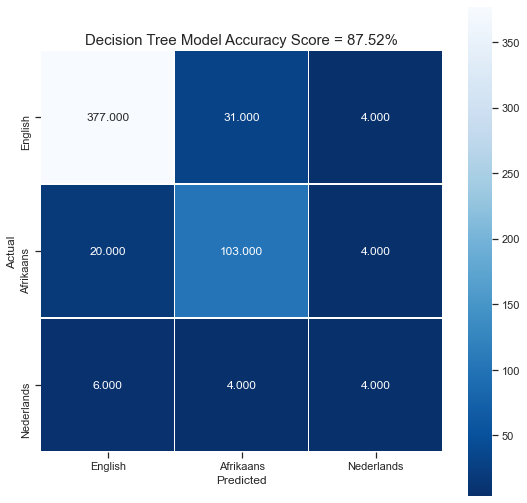

In [33]:
labels = ['English', 'Afrikaans', 'Nederlands']
# Confusion Matrix
cm_Model_dt = confusion_matrix(y_test, y_pred, labels)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
sns.heatmap(cm_Model_dt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
title = 'Decision Tree Model Accuracy Score = '+ str(round(accuracy_score_dt*100,2)) +"%"
plt.title(title, size = 15)

The graph above shows how many texts were categorized correctly in each of the languages, with the y-axis representing actual or actual output and the x-axis representing expected output. This tells us that the model does well at predicting English texts, in addition to Afrikaans texts.